# Image Quality Analysis

This notebook loads two datasets of fossil images for quality analysis:

- **OVC dataset**: images from Oervondstchecker (e.g. `images_ovc/`)
- **NBC dataset**: research grade images from Naturalis (e.g. `images_nbc/`)

OVC images found: 118
NBC images found: 118


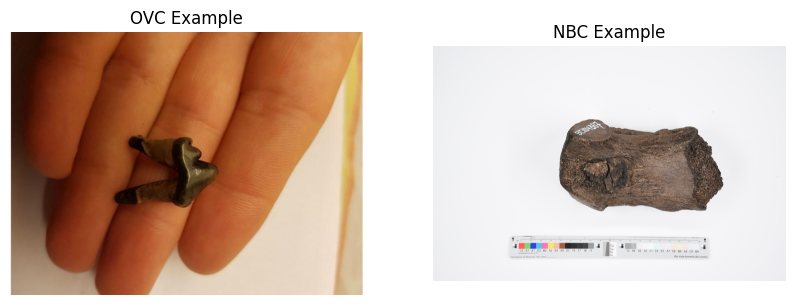

In [1]:
import os
from glob import glob

# Set dataset folders
ovc_folder = 'images_ovc'
nbc_folder = 'images_nbc'

# Get image file lists
ovc_images = sorted(glob(os.path.join(ovc_folder, '*')))
nbc_images = sorted(glob(os.path.join(nbc_folder, '*')))

print(f'OVC images found: {len(ovc_images)}')
print(f'NBC images found: {len(nbc_images)}')

# Example: show first image from each dataset
from PIL import Image
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.title('OVC Example')
plt.imshow(Image.open(ovc_images[0]))
plt.axis('off')

plt.subplot(1,2,2)
plt.title('NBC Example')
plt.imshow(Image.open(nbc_images[0]))
plt.axis('off')
plt.show()

## Compute BRISQUE and more for OVC and NBC datasets

In [2]:
import cv2
import numpy as np
import piq
from PIL import Image
import torch
import torchvision.transforms as T
from skimage import io
from skimage.color import rgb2gray
from skimage.measure import shannon_entropy

# ---- Extra Metrics ----

def calculate_sharpness(img_path):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        return float('nan')
    return cv2.Laplacian(img, cv2.CV_64F).var()

def calculate_entropy(img_path):
    img = io.imread(img_path)
    gray = rgb2gray(img)
    return shannon_entropy(gray)

def calculate_colorfulness(img_path):
    img = cv2.imread(img_path)
    if img is None: return float('nan')
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    (R, G, B) = cv2.split(img.astype("float"))
    rg = np.absolute(R - G)
    yb = np.absolute(0.5*(R + G) - B)
    std_root = np.sqrt((rg.std()**2) + (yb.std()**2))
    mean_root = np.sqrt((rg.mean()**2) + (yb.mean()**2))
    return std_root + (0.3 * mean_root)

def calculate_snr(img_path):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    if img is None: return float('nan')
    mean = np.mean(img)
    std = np.std(img)
    return 0 if std == 0 else mean / std

def get_scores(img_path):
    try:
        img = Image.open(img_path).convert('RGB')
    except Exception:
        return [float('nan')]*5

    transform = T.ToTensor()
    img_tensor = transform(img).unsqueeze(0)

    # BRISQUE
    try:
        brisque_score = piq.brisque(img_tensor).item()
    except Exception:
        brisque_score = float('nan')

    return [
        brisque_score,
        calculate_sharpness(img_path),
        calculate_entropy(img_path),
        calculate_colorfulness(img_path),
        calculate_snr(img_path)
    ]

# ---- Process datasets ----
metrics_names = ["BRISQUE", "Sharpness", "Entropy", "Colorfulness", "SNR"]

def process_dataset(img_list):
    results = {name: [] for name in metrics_names}
    for path in img_list:
        scores = get_scores(path)
        for name, val in zip(metrics_names, scores):
            results[name].append(val)
    return results

ovc_results = process_dataset(ovc_images)
nbc_results = process_dataset(nbc_images)

# ---- Print averages ----
print("OVC Averages:")
for m in metrics_names:
    print(f"{m}: {np.nanmean(ovc_results[m]):.3f}")

print("\nNBC Averages:")
for m in metrics_names:
    print(f"{m}: {np.nanmean(nbc_results[m]):.3f}")


KeyboardInterrupt: 

In [ ]:
%pip install huggingface_hub

import pyiqa
import torch
from PIL import Image
import torchvision.transforms as T

# Initialize models
brisque_model = pyiqa.create_metric('brisque')
niqe_model    = pyiqa.create_metric('niqe')
piqe_model    = pyiqa.create_metric('piqe')

transform = T.ToTensor()

def calc_iqa_scores(img_path):
    img = Image.open(img_path).convert('RGB')
    img_tensor = transform(img).unsqueeze(0)

    brisque = brisque_model(img_tensor).item()
    niqe    = niqe_model(img_tensor).item()
    piqe    = piqe_model(img_tensor).item()

    return brisque, niqe, piqe


Note: you may need to restart the kernel to use updated packages.


## Visualize average image quality metrics

  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.2
[notice] To update, run: C:\Users\megan\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


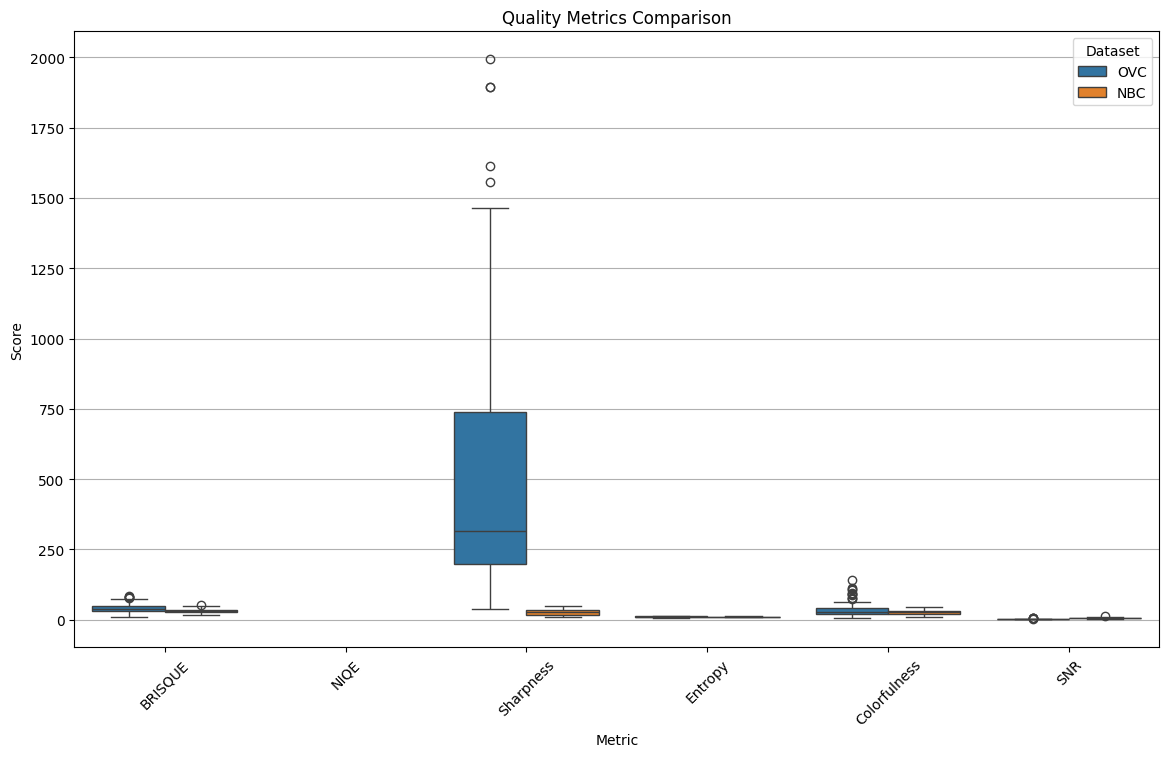

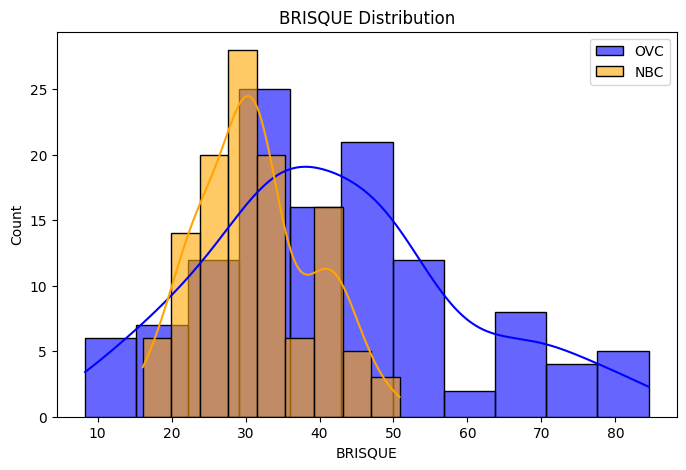

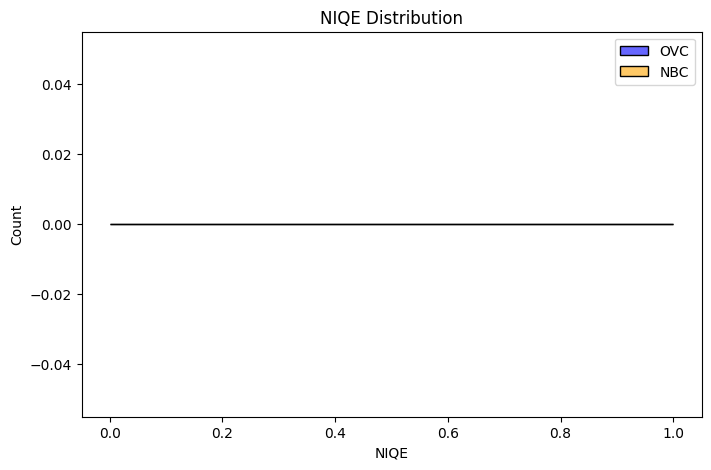

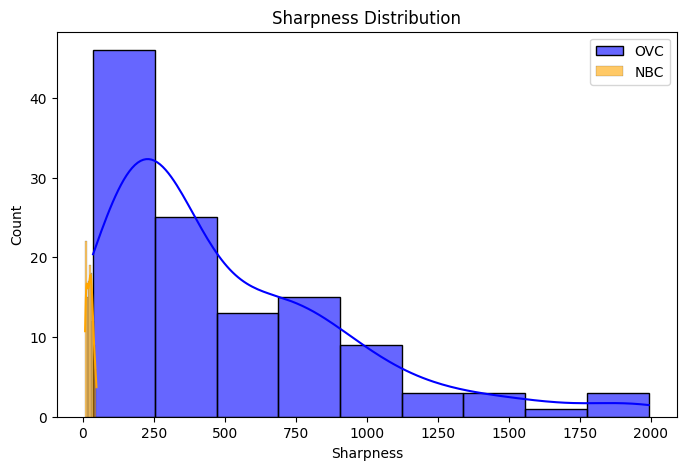

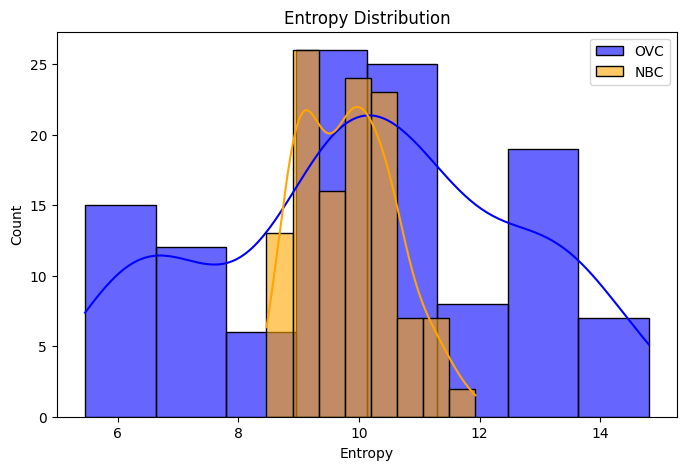

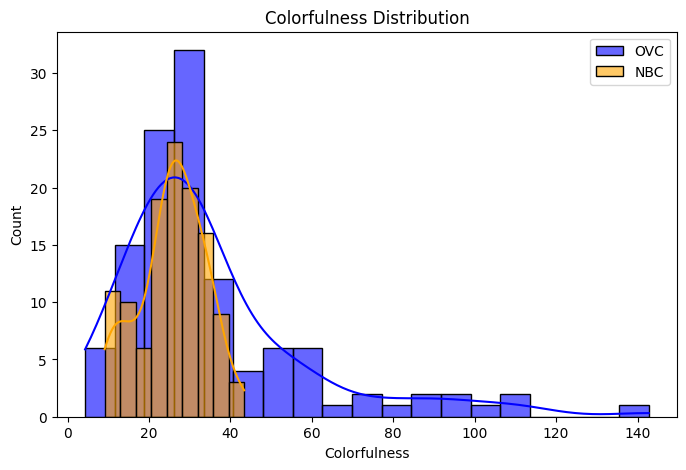

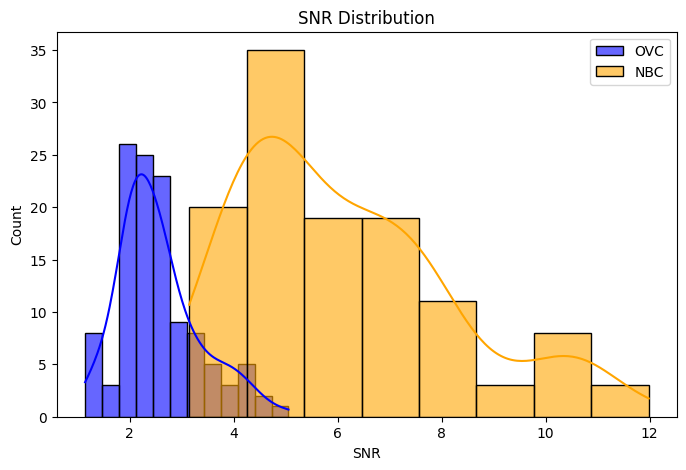

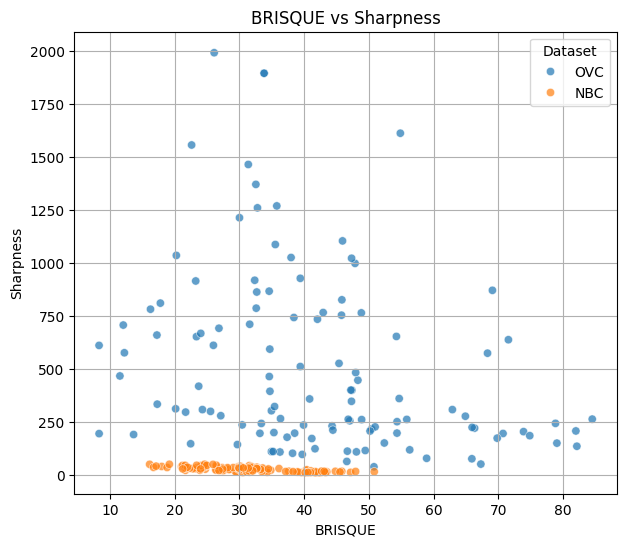

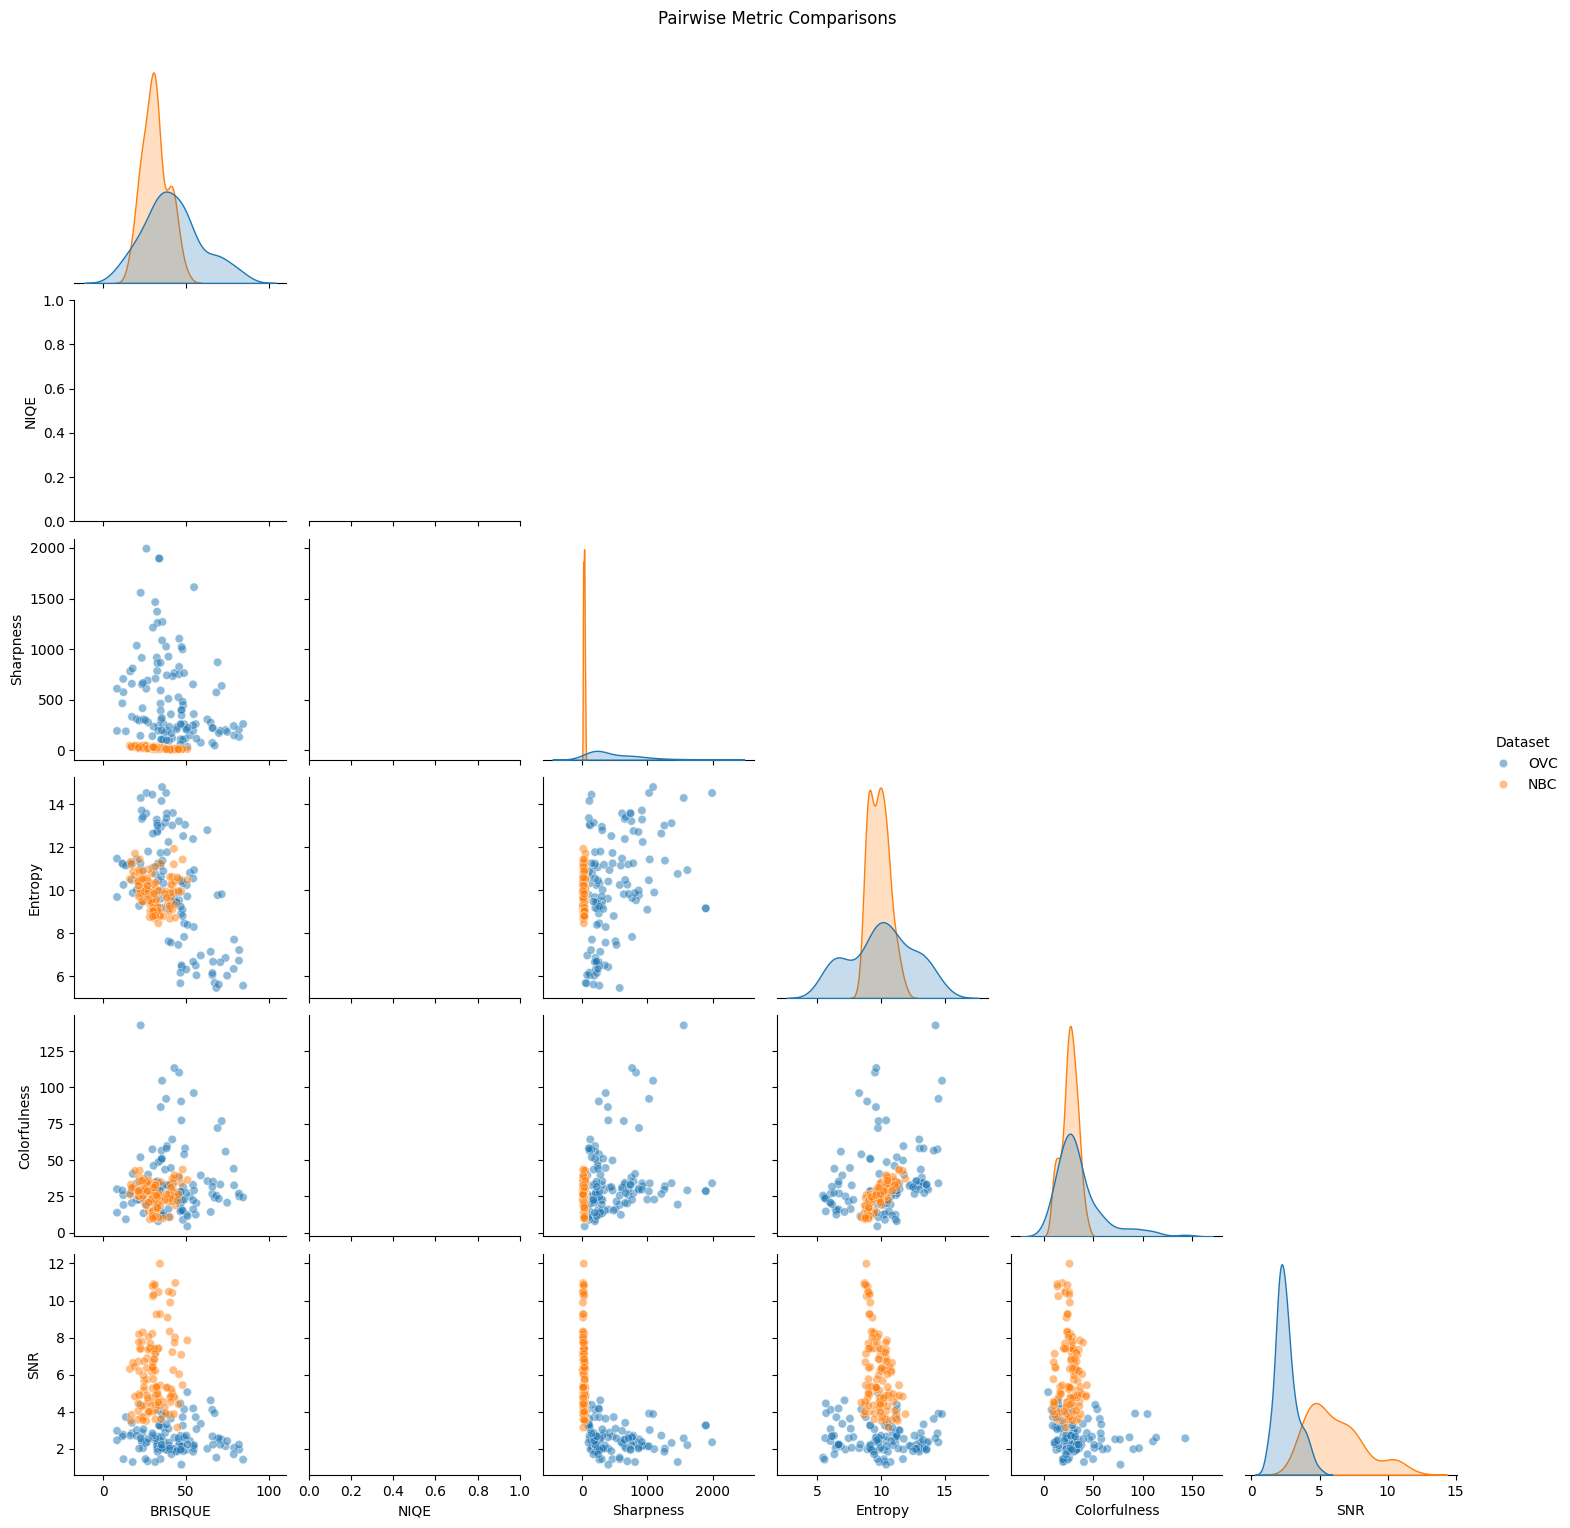

In [ ]:
%pip install seaborn

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Convert results to DataFrame for seaborn
def results_to_df(results, label):
    df = pd.DataFrame(results)
    df["Dataset"] = label
    return df

df_ovc = results_to_df(ovc_results, "OVC")
df_nbc = results_to_df(nbc_results, "NBC")
df_all = pd.concat([df_ovc, df_nbc])

# --- Boxplots for each metric ---
plt.figure(figsize=(14,8))
df_all_melt = df_all.melt(id_vars="Dataset", var_name="Metric", value_name="Score")
sns.boxplot(x="Metric", y="Score", hue="Dataset", data=df_all_melt)
plt.title("Quality Metrics Comparison")
plt.xticks(rotation=45)
plt.grid(True, axis="y")
plt.show()

# --- Histograms ---
for m in metrics_names:
    plt.figure(figsize=(8,5))
    sns.histplot(df_all[df_all["Dataset"]=="OVC"][m], label="OVC", kde=True, color="blue", alpha=0.6)
    sns.histplot(df_all[df_all["Dataset"]=="NBC"][m], label="NBC", kde=True, color="orange", alpha=0.6)
    plt.title(f"{m} Distribution")
    plt.xlabel(m)
    plt.legend()
    plt.show()

# --- Scatter plot: BRISQUE vs Sharpness ---
plt.figure(figsize=(7,6))
sns.scatterplot(data=df_all, x="BRISQUE", y="Sharpness", hue="Dataset", alpha=0.7)
plt.title("BRISQUE vs Sharpness")
plt.grid(True)
plt.show()

# --- Pairplot across all metrics ---
sns.pairplot(df_all, hue="Dataset", vars=metrics_names, corner=True, plot_kws={"alpha":0.5})
plt.suptitle("Pairwise Metric Comparisons", y=1.02)
plt.show()


# Image Quality Metric Interpretation & Troubleshooting

**BRISQUE, Sharpness: What do the scores mean?**

- **BRISQUE**: Lower values indicate better perceptual image quality. Typical range: 0 (best) to ~100 (worst).  
- **Sharpness**: Higher values indicate sharper images. Calculated as the variance of the Laplacian (no fixed range, but higher is better).

**Troubleshooting Calculation:**
- If scores are `nan` or missing, check:
  - The image is readable and not corrupted.
  - The image is in a supported format (e.g. PNG, JPG).
  - The image is not too small (should be at least 128x128 pixels).
  - The required libraries (`piq`, `opencv-python`, `torchvision`) are installed and up to date.

**Example:**

In [10]:
import cv2
import numpy as np
from skimage import io, color, exposure, filters
from skimage.restoration import estimate_sigma
from skimage.measure import shannon_entropy
from scipy.fftpack import fft2, fftshift


def compute_quality_metrics(image_path):
    img = cv2.imread(image_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    metrics = {}

    # ✅ Tenengrad sharpness (edge-based)
    gx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)
    gy = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=3)
    metrics["sharpness_tenengrad"] = np.mean(gx**2 + gy**2)

    # ✅ FFT sharpness (high-frequency energy)
    f = np.abs(fftshift(fft2(gray)))
    h, w = gray.shape
    crow, ccol = h//2, w//2
    high_freq = f[crow-50:crow+50, ccol-50:ccol+50]  # center = low freq
    metrics["sharpness_fft"] = np.sum(f) - np.sum(high_freq)

    # ✅ Entropy (image detail / complexity)
    metrics["entropy"] = shannon_entropy(gray)

    # ✅ RMS Contrast
    metrics["contrast"] = gray.std()

    # ✅ Noise estimation (standard deviation of wavelet residuals)
    sigma_est = estimate_sigma(gray, channel_axis=None, average_sigmas=True)
    metrics["noise"] = sigma_est


    # ✅ Illumination uniformity (std of mean-normalized image)
    norm = gray / gray.mean()
    metrics["illumination_uniformity"] = np.std(norm)

    return metrics


In [12]:
import os
import pandas as pd
from tqdm import tqdm

def analyze_dataset(folder, label):
    results = []
    for fname in tqdm(os.listdir(folder)):
        if fname.lower().endswith(".jpg"):
            fpath = os.path.join(folder, fname)
            try:
                metrics = compute_quality_metrics(fpath)
                metrics["dataset"] = label
                metrics["file"] = fname
                results.append(metrics)
            except Exception as e:
                print(f"Error processing {fname}: {e}")
    return pd.DataFrame(results)

# Example usage
nbc_df = analyze_dataset("images_nbc", "NBC")
ovc_df = analyze_dataset("images_ovc", "OVC")

df = pd.concat([nbc_df, ovc_df], ignore_index=True)


100%|██████████| 118/118 [00:03<00:00, 31.19it/s]


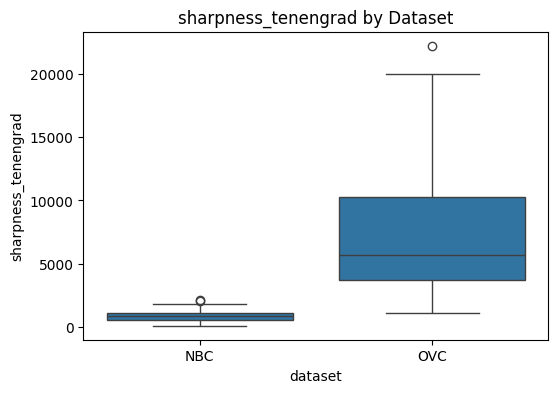

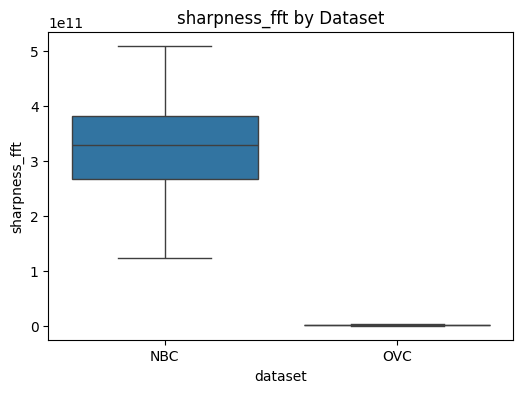

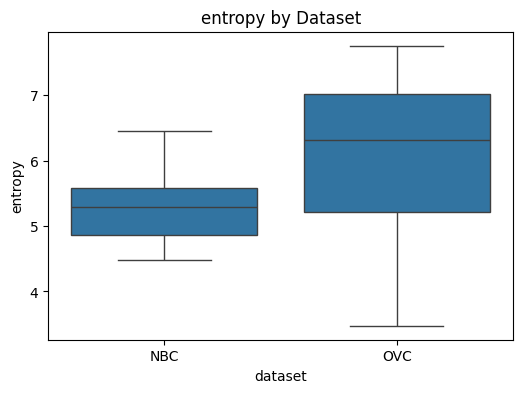

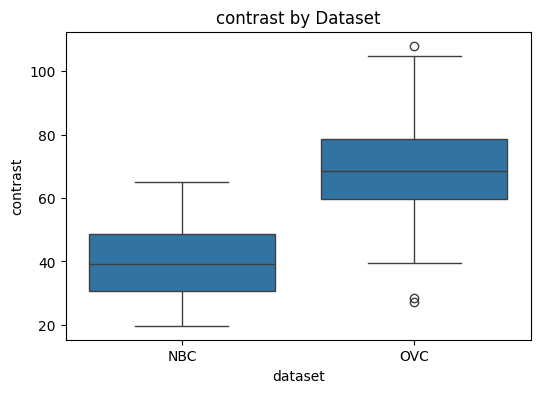

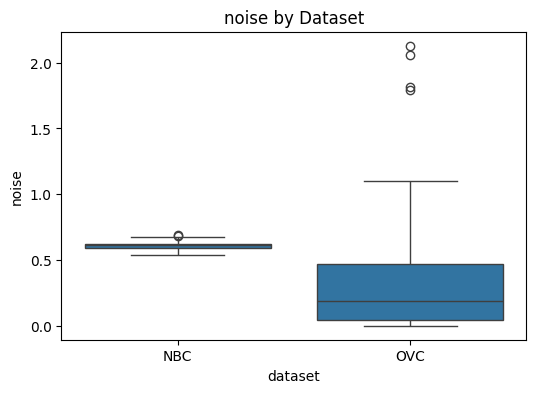

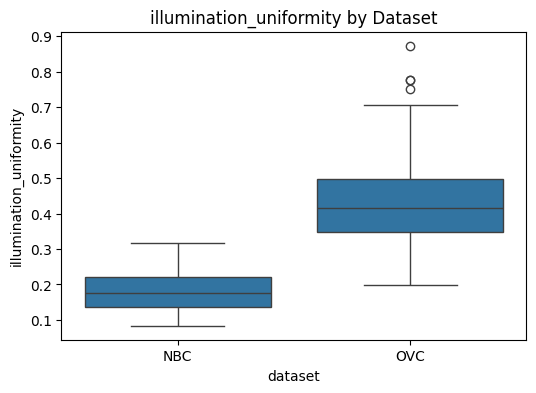

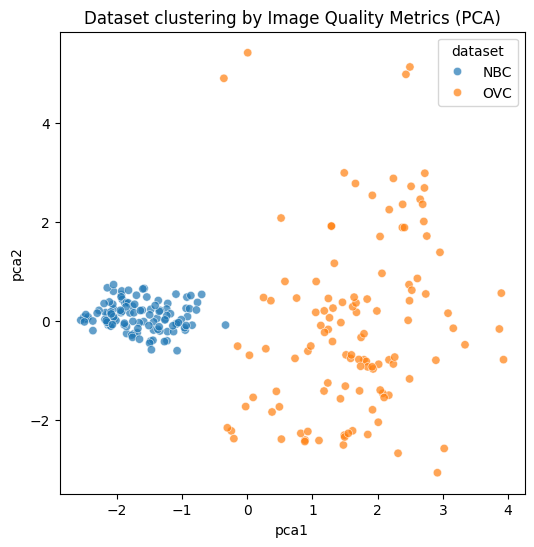

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

metrics = ["sharpness_tenengrad", "sharpness_fft", 
           "entropy", "contrast", "noise", "illumination_uniformity"]

# Boxplots per metric
for m in metrics:
    plt.figure(figsize=(6,4))
    sns.boxplot(x="dataset", y=m, data=df)
    plt.title(f"{m} by Dataset")
    plt.show()

# PCA clustering of metrics
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

X = df[metrics].values
X_scaled = StandardScaler().fit_transform(X)
pca = PCA(n_components=2)
pca_result = pca.fit_transform(X_scaled)

df["pca1"], df["pca2"] = pca_result[:,0], pca_result[:,1]

plt.figure(figsize=(6,6))
sns.scatterplot(x="pca1", y="pca2", hue="dataset", data=df, alpha=0.7)
plt.title("Dataset clustering by Image Quality Metrics (PCA)")
plt.show()
